# Experiments

### Setup

In [1]:

from dotenv import load_dotenv
load_dotenv(dotenv_path="../../.env", override=True)

True

Here is the RAG Application that we've been working with throughout this course

In [2]:
import os
import tempfile
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders.sitemap import SitemapLoader
from langchain_community.vectorstores import SKLearnVectorStore
from langchain_openai import OpenAIEmbeddings
from langsmith import traceable
from openai import OpenAI
from typing import List
import nest_asyncio

# TODO: Configure this model!
MODEL_NAME = "gpt-3.5-turbo"
MODEL_PROVIDER = "openai"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()

def get_vector_db_retriever():
    persist_path = os.path.join(tempfile.gettempdir(), "union.parquet")
    embd = OpenAIEmbeddings()

    # If vector store exists, then load it
    if os.path.exists(persist_path):
        vectorstore = SKLearnVectorStore(
            embedding=embd,
            persist_path=persist_path,
            serializer="parquet"
        )
        return vectorstore.as_retriever(lambda_mult=0)

    # Otherwise, index LangSmith documents and create new vector store
    ls_docs_sitemap_loader = SitemapLoader(web_path="https://docs.smith.langchain.com/sitemap.xml", continue_on_failure=True)
    ls_docs = ls_docs_sitemap_loader.load()

    text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
        chunk_size=500, chunk_overlap=0
    )
    doc_splits = text_splitter.split_documents(ls_docs)

    vectorstore = SKLearnVectorStore.from_documents(
        documents=doc_splits,
        embedding=embd,
        persist_path=persist_path,
        serializer="parquet"
    )
    vectorstore.persist()
    return vectorstore.as_retriever(lambda_mult=0)

nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable(run_type="chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
@traceable(run_type="chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    return call_openai(messages)

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable(
    run_type="llm",
    metadata={
        "ls_provider": MODEL_PROVIDER,
        "ls_model_name": MODEL_NAME
    }
)
def call_openai(messages: List[dict]) -> str:
    return openai_client.chat.completions.create(
        model=MODEL_NAME,
        messages=messages,
    )

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable(run_type="chain")
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content


USER_AGENT environment variable not set, consider setting it to identify your requests.


### Experiment

Here is a code snippet that should look similar to what you see from the starter code!

There are a few important components here.

1. We have defined an Evaluator
2. We pipe our dataset examples (dict) to the shape of input that our function `langsmith_rag` takes (str) using a target function

In [4]:
from langsmith import evaluate, Client
from tqdm.auto import tqdm

# Temporarily disable notebook bars
tqdm().disable = True

client = Client()
dataset_name = "RAG Application Golden Dataset"

def is_concise_enough(reference_outputs: dict, outputs: dict) -> dict:
    score = len(outputs["output"]) < 1.5 * len(reference_outputs["output"])
    return {"key": "is_concise", "score": int(score)}

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-4o"
)

0it [00:00, ?it/s]

View the evaluation results for experiment: 'gpt-4o-001feeea' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/ff1e2ce7-be51-4518-8cba-8372e764ba60/compare?selectedSessions=01ddee16-0beb-447d-8cd9-0e8672d189ea




15it [00:33,  2.23s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I pass metadata in with @traceable?,"To pass metadata with `@traceable`, you can in...",None,You can pass metadata with the @traceable deco...,1,2.873723,057abec0-6840-47d8-8851-1fa1eab17bce,e656f955-e13a-4928-a858-f80b39435314
1,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,1.441854,2f35c1bc-5bad-4853-b5bc-57cd1a0d0c32,d66eb17e-223b-4e19-9308-f01f8790a880
2,Can LangSmith be used for finetuning and model...,LangSmith is primarily a platform for LLM obse...,None,"Yes, LangSmith can be used for fine-tuning and...",1,2.577185,67822ff3-4f1e-45ee-8d24-90bf09f2af8a,fecab12d-16d2-4d43-9734-24e6cab6b658
3,What features does LangSmith offer for debuggi...,LangSmith offers a range of features for debug...,None,LangSmith offers various features for debuggin...,1,1.781804,67e57814-661a-4583-a335-7ab049a6b4b7,c534a49b-35ea-4977-bf35-3808ec25af4b
4,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,3.285271,b5e45520-feb7-4d4f-a4d1-00a983e1fc1b,085406de-90f8-4778-9d8c-ba05c1536ff7
5,How do I generate test cases with LangSmith?,"To generate test cases with LangSmith, first c...",None,"To generate test cases with LangSmith, you can...",1,1.965556,e34d0364-418c-4463-b665-69e7fd543bac,c6c72310-39b1-47c2-9ef4-f5a34902a430
6,Can LangSmith integrate with external data sou...,"Yes, LangSmith can integrate with external dat...",None,"Yes, LangSmith can integrate with various exte...",1,1.698918,19e5fc6c-e620-45c5-852f-aba45548691c,26e77604-674d-4e10-9872-1e24915a02e3
7,Is there a JavaScript LangSmith SDK?,"Yes, there is a JavaScript LangSmith SDK that ...",None,"Yes, there a JavaScript LangSmith SDK?",0,1.345117,be707faf-9e8b-4d49-9a05-843e036bf0e9,5c1d9739-4da3-4c1e-aaeb-a5bf3ffcc7cb
8,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,"To set up tracing to LangSmith with LangChain,...",1,2.741687,414d1fb1-8d75-4de4-a41c-ef7fae7ac392,7d206bb2-3bec-426e-96ba-7c56bb1f5fc7
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.947201,2e21bda9-70c3-4280-937c-2dd91f4566ff,cdc940f5-3374-475f-bdf9-f02e2ffcda34


### Modifying your Application

Now, let's change our model to gpt-35-turbo and see how it performs!

Make this change, and then run this code snippet!

In [5]:
from langsmith import evaluate, Client
from langsmith.schemas import Example, Run

def target_function(inputs: dict):
    return langsmith_rag(inputs["question"])

evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="gpt-3.5-turbo"
)

View the evaluation results for experiment: 'gpt-3.5-turbo-e63b241c' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/ff1e2ce7-be51-4518-8cba-8372e764ba60/compare?selectedSessions=69b8faa5-bc8c-4e18-9eb0-dabd124264d3




15it [00:39,  2.61s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I pass metadata in with @traceable?,"To pass metadata in with `@traceable`, you can...",None,You can pass metadata with the @traceable deco...,1,3.538752,057abec0-6840-47d8-8851-1fa1eab17bce,7eb0c120-9c30-4082-a916-ed582621d7a0
1,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,1.696674,2f35c1bc-5bad-4853-b5bc-57cd1a0d0c32,a29ae019-69f5-4cb7-9f0d-9d99f170d029
2,Can LangSmith be used for finetuning and model...,"LangSmith is primarily designed for building, ...",None,"Yes, LangSmith can be used for fine-tuning and...",1,2.131126,67822ff3-4f1e-45ee-8d24-90bf09f2af8a,42dd819c-02c3-4b08-bbaa-1d489bb3dea6
3,What features does LangSmith offer for debuggi...,LangSmith offers a platform with components li...,None,LangSmith offers various features for debuggin...,1,2.303675,67e57814-661a-4583-a335-7ab049a6b4b7,681134d7-05d5-41ed-a299-b002b4ac2ece
4,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,1.992319,b5e45520-feb7-4d4f-a4d1-00a983e1fc1b,dfb30059-b651-44ed-bba3-813496b5e684
5,How do I generate test cases with LangSmith?,"To generate test cases with LangSmith, begin b...",None,"To generate test cases with LangSmith, you can...",1,5.477720,e34d0364-418c-4463-b665-69e7fd543bac,b7884470-a884-4c26-803d-93a87e779b02
6,Can LangSmith integrate with external data sou...,"Yes, LangSmith can integrate with external dat...",None,"Yes, LangSmith can integrate with various exte...",1,1.815687,19e5fc6c-e620-45c5-852f-aba45548691c,dacb7a00-9251-4313-9bab-730238e57145
7,Is there a JavaScript LangSmith SDK?,"Yes, there is a JavaScript SDK for LangSmith, ...",None,"Yes, there a JavaScript LangSmith SDK?",0,1.143647,be707faf-9e8b-4d49-9a05-843e036bf0e9,21c1f7ac-b6b4-4e19-9e7c-eb2ac7ee60e7
8,How do I set up tracing to LangSmith if I'm us...,"To set up tracing to LangSmith with LangChain,...",None,"To set up tracing to LangSmith with LangChain,...",1,3.002806,414d1fb1-8d75-4de4-a41c-ef7fae7ac392,cceed0df-7477-400e-8f0c-44d7ba9e376a
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.932530,2e21bda9-70c3-4280-937c-2dd91f4566ff,a9181b4c-d4cd-4b98-b6f1-f16c287ff42b


### Running over Different pieces of Data

##### Dataset Version

You can execute an experiment on a specific version of a dataset in the sdk by using the `as_of` parameter in `list_examples`

Let's try running on just our initial dataset.

Observation:  We can see that this experiment ran on the first 10 examples that we added

In [6]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, as_of="initial dataset"),   # We use as_of to specify a version
    evaluators=[is_concise_enough],
    experiment_prefix="initial dataset version"
)



View the evaluation results for experiment: 'initial dataset version-fed3b626' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/ff1e2ce7-be51-4518-8cba-8372e764ba60/compare?selectedSessions=1e0496e4-4949-4790-a2fb-5617f8c46f1b




10it [00:22,  2.27s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I pass metadata in with @traceable?,"To pass metadata with `@traceable`, you can in...",None,You can pass metadata with the @traceable deco...,1,2.102873,057abec0-6840-47d8-8851-1fa1eab17bce,7e9acce9-1dc5-464a-b880-5fa4aff11300
1,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.821691,2e21bda9-70c3-4280-937c-2dd91f4566ff,b948f2c9-76f1-4751-9938-fe3a4406622f
2,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,2.420017,2f35c1bc-5bad-4853-b5bc-57cd1a0d0c32,0871485b-921b-42ab-92d3-a5a79516c092
3,What testing capabilities does LangSmith have?,LangSmith allows users to run multiple experim...,None,LangSmith offers capabilities for creating dat...,1,1.598893,40f73ead-5b6c-43f1-beba-a532da900beb,ba280c08-fba2-4a84-bfb9-27f011c8d9bc
4,How can I trace with the @traceable decorator?,To trace with the @traceable decorator in Pyth...,None,To trace with the @traceable decorator in Pyth...,1,3.283229,4e8a27be-b32a-4157-8403-d68cedf6a69f,b9661894-4b92-45f2-bfce-a20ab45fc53b
5,Can LangSmith be used for finetuning and model...,"No, LangSmith is primarily designed for monito...",None,"Yes, LangSmith can be used for fine-tuning and...",1,1.566590,67822ff3-4f1e-45ee-8d24-90bf09f2af8a,95a31989-541d-42ea-a82d-4b48bc102a36
6,What is LangSmith used for in three sentences?,LangSmith is used to run and manage experiment...,None,LangSmith is a platform designed for the devel...,1,2.162693,addbdb2a-0543-4e6c-9e90-ffd10f90b039,dcda5268-8c1d-4f32-b3e0-713623584542
7,Does LangSmith support offline evaluation?,LangSmith primarily supports online evaluation...,None,"Yes, LangSmith supports offline evaluation thr...",1,1.710906,b1ddea60-5eb2-4246-a2c2-cabc5341f6e3,c13d051a-1e54-4988-b034-f3da2aa48a73
8,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,2.754210,b5e45520-feb7-4d4f-a4d1-00a983e1fc1b,48ea62f6-140d-40b6-beaf-cffd70248fd2
9,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,To set up tracing to LangSmith while using Lan...,0,2.421554,f5a51cec-4ea9-4112-b697-ea9589116f73,c9231d49-a90e-4074-9453-bae1f85c6c1e


##### Dataset Split

You can run an experiment on a specific split of your dataset, let's try running on the Crucial Examples split.

In [7]:
evaluate(
    target_function,
    data=client.list_examples(dataset_name=dataset_name, splits=["Crucial Examples"]),  # We pass in a list of Splits
    evaluators=[is_concise_enough],
    experiment_prefix="Crucial Examples split"
)

View the evaluation results for experiment: 'Crucial Examples split-99712867' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/ff1e2ce7-be51-4518-8cba-8372e764ba60/compare?selectedSessions=9df13de7-818c-4d43-9931-5aa3517bf06f




6it [00:15,  2.56s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I pass metadata in with @traceable?,"To pass metadata in with `@traceable`, you can...",None,You can pass metadata with the @traceable deco...,0,3.751021,057abec0-6840-47d8-8851-1fa1eab17bce,90c6c717-a087-4399-9691-29b8b0c3106f
1,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation to p...",None,"Yes, LangSmith supports online evaluation as a...",0,2.049589,2f35c1bc-5bad-4853-b5bc-57cd1a0d0c32,0482df8e-98dc-4335-9b4b-ed61b117f69d
2,Can LangSmith be used for finetuning and model...,"No, LangSmith is not designed for finetuning a...",None,"Yes, LangSmith can be used for fine-tuning and...",1,1.998159,67822ff3-4f1e-45ee-8d24-90bf09f2af8a,13edd7aa-0bea-476f-8bfd-07708056c80f
3,What features does LangSmith offer for debuggi...,LangSmith offers several features for debuggin...,None,LangSmith offers various features for debuggin...,1,2.095525,67e57814-661a-4583-a335-7ab049a6b4b7,fa20ce1f-b576-41b7-8a00-1323b13b495c
4,How do I create user feedback with the LangSmi...,To create user feedback using the LangSmith SD...,None,To create user feedback with the LangSmith SDK...,1,2.983460,b5e45520-feb7-4d4f-a4d1-00a983e1fc1b,a09ee237-264e-4dc2-b72c-8e94e1a4ce3c
5,How do I generate test cases with LangSmith?,"To generate test cases with LangSmith, start b...",None,"To generate test cases with LangSmith, you can...",1,1.984575,e34d0364-418c-4463-b665-69e7fd543bac,c1f3e619-9059-4e92-9744-caad6de086f9


##### Specific Data Points

You can specify individual data points to run an experiment over as well

In [9]:
evaluate(
    target_function,
    data=client.list_examples(
        dataset_name=dataset_name, 
        example_ids=[   # We pass in a specific list of example_ids
            "414d1fb1-8d75-4de4-a41c-ef7fae7ac392",
        ]
    ),
    evaluators=[is_concise_enough],
    experiment_prefix="two specific example ids"
)

View the evaluation results for experiment: 'two specific example ids-997f6e70' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/ff1e2ce7-be51-4518-8cba-8372e764ba60/compare?selectedSessions=151317a5-89aa-4a06-bfdc-03d73ff6fe33




1it [00:03,  3.36s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,"To set up tracing to LangSmith with LangChain,...",0,2.740623,414d1fb1-8d75-4de4-a41c-ef7fae7ac392,0da4d266-09ac-4e4c-a19f-ea3d910b8d5e


### Other Parameters

##### Repetitions

You can run an experiment several times to make sure you have consistent results

In [10]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="two repetitions",
    num_repetitions=2   # This field defaults to 1
)

View the evaluation results for experiment: 'two repetitions-50b783bc' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/ff1e2ce7-be51-4518-8cba-8372e764ba60/compare?selectedSessions=7d3e1d72-342d-494e-9de6-0171066102fb




30it [01:11,  2.37s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I pass metadata in with @traceable?,"To pass metadata in with `@traceable`, you can...",None,You can pass metadata with the @traceable deco...,1,4.614280,057abec0-6840-47d8-8851-1fa1eab17bce,c1deb2a4-de2c-47db-ace3-85fd52ae6d20
1,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation to p...",None,"Yes, LangSmith supports online evaluation as a...",1,2.033878,2f35c1bc-5bad-4853-b5bc-57cd1a0d0c32,9b39bfe7-266a-462b-8495-9d11117f7914
2,Can LangSmith be used for finetuning and model...,LangSmith is designed primarily for monitoring...,None,"Yes, LangSmith can be used for fine-tuning and...",1,3.047069,67822ff3-4f1e-45ee-8d24-90bf09f2af8a,89dbad02-a586-4875-b318-f6df825372a2
3,What features does LangSmith offer for debuggi...,LangSmith offers features such as a frontend a...,None,LangSmith offers various features for debuggin...,1,2.397956,67e57814-661a-4583-a335-7ab049a6b4b7,9e2a64a9-d622-45e6-b190-4fc652bdcdd1
4,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,2.925183,b5e45520-feb7-4d4f-a4d1-00a983e1fc1b,e8b9cbec-79f8-4fa3-8046-5ea90962d3f0
5,How do I generate test cases with LangSmith?,"To generate test cases with LangSmith, you nee...",None,"To generate test cases with LangSmith, you can...",1,2.091690,e34d0364-418c-4463-b665-69e7fd543bac,dfd8e367-b653-45ca-8ac2-aa9401886dfa
6,Can LangSmith integrate with external data sou...,"Yes, LangSmith can integrate with external dat...",None,"Yes, LangSmith can integrate with various exte...",1,2.032396,19e5fc6c-e620-45c5-852f-aba45548691c,b21793ed-41ae-4c6e-8653-f438c88badfc
7,Is there a JavaScript LangSmith SDK?,"Yes, there is a JavaScript (and TypeScript) La...",None,"Yes, there a JavaScript LangSmith SDK?",0,1.592548,be707faf-9e8b-4d49-9a05-843e036bf0e9,88cb6d36-ca06-4da8-b3fa-9c7e7ec2bdad
8,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,"To set up tracing to LangSmith with LangChain,...",1,2.129050,414d1fb1-8d75-4de4-a41c-ef7fae7ac392,c74a1ce2-2997-409d-9558-2b4f4baf2223
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,1.839765,2e21bda9-70c3-4280-937c-2dd91f4566ff,016bd23b-d690-4915-ac7a-c9dfbb273d56


##### Concurrency
You can also kick off concurrent threads of execution to make your experiments finish faster!

In [11]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="concurrency",
    max_concurrency=3,  # This defaults to None, so this is an improvement!
)

View the evaluation results for experiment: 'concurrency-8a38ea14' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/ff1e2ce7-be51-4518-8cba-8372e764ba60/compare?selectedSessions=678da628-5018-4726-abb2-cd627fa72eaa




15it [00:15,  1.03s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation. It ...",None,"Yes, LangSmith supports online evaluation as a...",1,2.546987,2f35c1bc-5bad-4853-b5bc-57cd1a0d0c32,6d1c9da4-8a07-4cdc-baa5-beaad4b4b40a
1,Can LangSmith be used for finetuning and model...,"LangSmith is focused on monitoring, evaluating...",None,"Yes, LangSmith can be used for fine-tuning and...",1,2.916813,67822ff3-4f1e-45ee-8d24-90bf09f2af8a,d31248a4-73f8-42c7-995a-75fbfc701312
2,How do I pass metadata in with @traceable?,"To pass metadata in with `@traceable`, you can...",None,You can pass metadata with the @traceable deco...,0,4.133466,057abec0-6840-47d8-8851-1fa1eab17bce,098cc0a2-10b2-465e-aec6-c3fa1bf1b20e
3,How do I create user feedback with the LangSmi...,To create user feedback using the LangSmith SD...,None,To create user feedback with the LangSmith SDK...,1,1.962927,b5e45520-feb7-4d4f-a4d1-00a983e1fc1b,7393f145-3228-44f4-8d35-d7e2bc2b015d
4,What features does LangSmith offer for debuggi...,LangSmith offers features such as a frontend i...,None,LangSmith offers various features for debuggin...,1,2.621400,67e57814-661a-4583-a335-7ab049a6b4b7,756ec1aa-368d-41b6-98f1-766569e78dce
5,Is there a JavaScript LangSmith SDK?,"Yes, there is a JavaScript LangSmith SDK. Lang...",None,"Yes, there a JavaScript LangSmith SDK?",0,1.275768,be707faf-9e8b-4d49-9a05-843e036bf0e9,4761c69a-d66a-41d1-bcd5-dc091292a691
6,How do I generate test cases with LangSmith?,"To generate test cases with LangSmith, you sta...",None,"To generate test cases with LangSmith, you can...",1,2.910561,e34d0364-418c-4463-b665-69e7fd543bac,31f015e8-fb85-4067-83f5-9bdac00662ff
7,Can LangSmith integrate with external data sou...,"Yes, LangSmith can integrate with external dat...",None,"Yes, LangSmith can integrate with various exte...",1,3.015576,19e5fc6c-e620-45c5-852f-aba45548691c,579c8c22-3c64-48b7-a021-9da9faa8626b
8,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,2.496895,2e21bda9-70c3-4280-937c-2dd91f4566ff,3717b4c9-2e01-488f-898d-194c1eb5367d
9,How do I set up tracing to LangSmith if I'm us...,"To set up tracing to LangSmith with LangChain,...",None,"To set up tracing to LangSmith with LangChain,...",1,3.134844,414d1fb1-8d75-4de4-a41c-ef7fae7ac392,7b31758c-822b-40db-b5e2-1b53c4b1d705


##### Metadata 

You can (and should) add metadata to your experiments, to make them easier to find in the UI

In [12]:
evaluate(
    target_function,
    data=dataset_name,
    evaluators=[is_concise_enough],
    experiment_prefix="metadata added",
    metadata={  # We can pass custom metadata for the experiment, such as the model name
        "model_name": MODEL_NAME
    }
)

View the evaluation results for experiment: 'metadata added-24c406b3' at:
https://smith.langchain.com/o/ca700a49-195a-43a4-baa7-fc421725599d/datasets/ff1e2ce7-be51-4518-8cba-8372e764ba60/compare?selectedSessions=ca5fd95d-0310-4fe6-ad53-78a08cc42d70




15it [01:24,  5.63s/it]


,inputs.question,outputs.output,error,reference.output,feedback.is_concise,execution_time,example_id,id
0,How do I pass metadata in with @traceable?,"To pass metadata with `@traceable`, you includ...",None,You can pass metadata with the @traceable deco...,1,26.690739,057abec0-6840-47d8-8851-1fa1eab17bce,daca7eac-a4fb-4415-a622-3c1089a5e9c1
1,Does LangSmith support online evaluation?,"Yes, LangSmith supports online evaluation thro...",None,"Yes, LangSmith supports online evaluation as a...",1,21.829548,2f35c1bc-5bad-4853-b5bc-57cd1a0d0c32,0ba5223b-af32-40b6-bf49-329f8b3a8187
2,Can LangSmith be used for finetuning and model...,LangSmith is primarily designed for monitoring...,None,"Yes, LangSmith can be used for fine-tuning and...",1,1.753584,67822ff3-4f1e-45ee-8d24-90bf09f2af8a,e4eefce7-0500-45e6-af56-1f01c74e8c44
3,What features does LangSmith offer for debuggi...,LangSmith offers a variety of features for deb...,None,LangSmith offers various features for debuggin...,1,2.626163,67e57814-661a-4583-a335-7ab049a6b4b7,0db9a3d0-a331-47c8-a22b-3407596e3d19
4,How do I create user feedback with the LangSmi...,To create user feedback with the LangSmith SDK...,None,To create user feedback with the LangSmith SDK...,1,2.567812,b5e45520-feb7-4d4f-a4d1-00a983e1fc1b,f17b755a-f2a4-45f7-a46b-7e6e942d5bec
5,How do I generate test cases with LangSmith?,"To generate test cases with LangSmith, you'll ...",None,"To generate test cases with LangSmith, you can...",1,3.315891,e34d0364-418c-4463-b665-69e7fd543bac,b0b218e0-cc53-4dd9-bce0-9f06e8ed98c7
6,Can LangSmith integrate with external data sou...,"Yes, LangSmith can integrate with external dat...",None,"Yes, LangSmith can integrate with various exte...",1,1.634087,19e5fc6c-e620-45c5-852f-aba45548691c,77f3f453-fa1d-41e4-82fa-f6a2ffed97cc
7,Is there a JavaScript LangSmith SDK?,"Yes, there is a JavaScript (JS/TS) LangSmith S...",None,"Yes, there a JavaScript LangSmith SDK?",0,1.174275,be707faf-9e8b-4d49-9a05-843e036bf0e9,fcb60c30-6c0d-44af-a370-acc999700816
8,How do I set up tracing to LangSmith if I'm us...,To set up tracing to LangSmith using LangChain...,None,"To set up tracing to LangSmith with LangChain,...",1,3.047732,414d1fb1-8d75-4de4-a41c-ef7fae7ac392,1fbbe7ba-3350-45d6-b39e-ff0a4bae0e98
9,Can LangSmith be used to evaluate agents?,"Yes, LangSmith can be used to evaluate agents....",None,"Yes, LangSmith can be used to evaluate agents....",1,7.311850,2e21bda9-70c3-4280-937c-2dd91f4566ff,08ffc02a-5252-4306-b192-a06914bf8aaa


### LANSGMITH PORTAL

We can see all the experiments that wwe ran populated here:

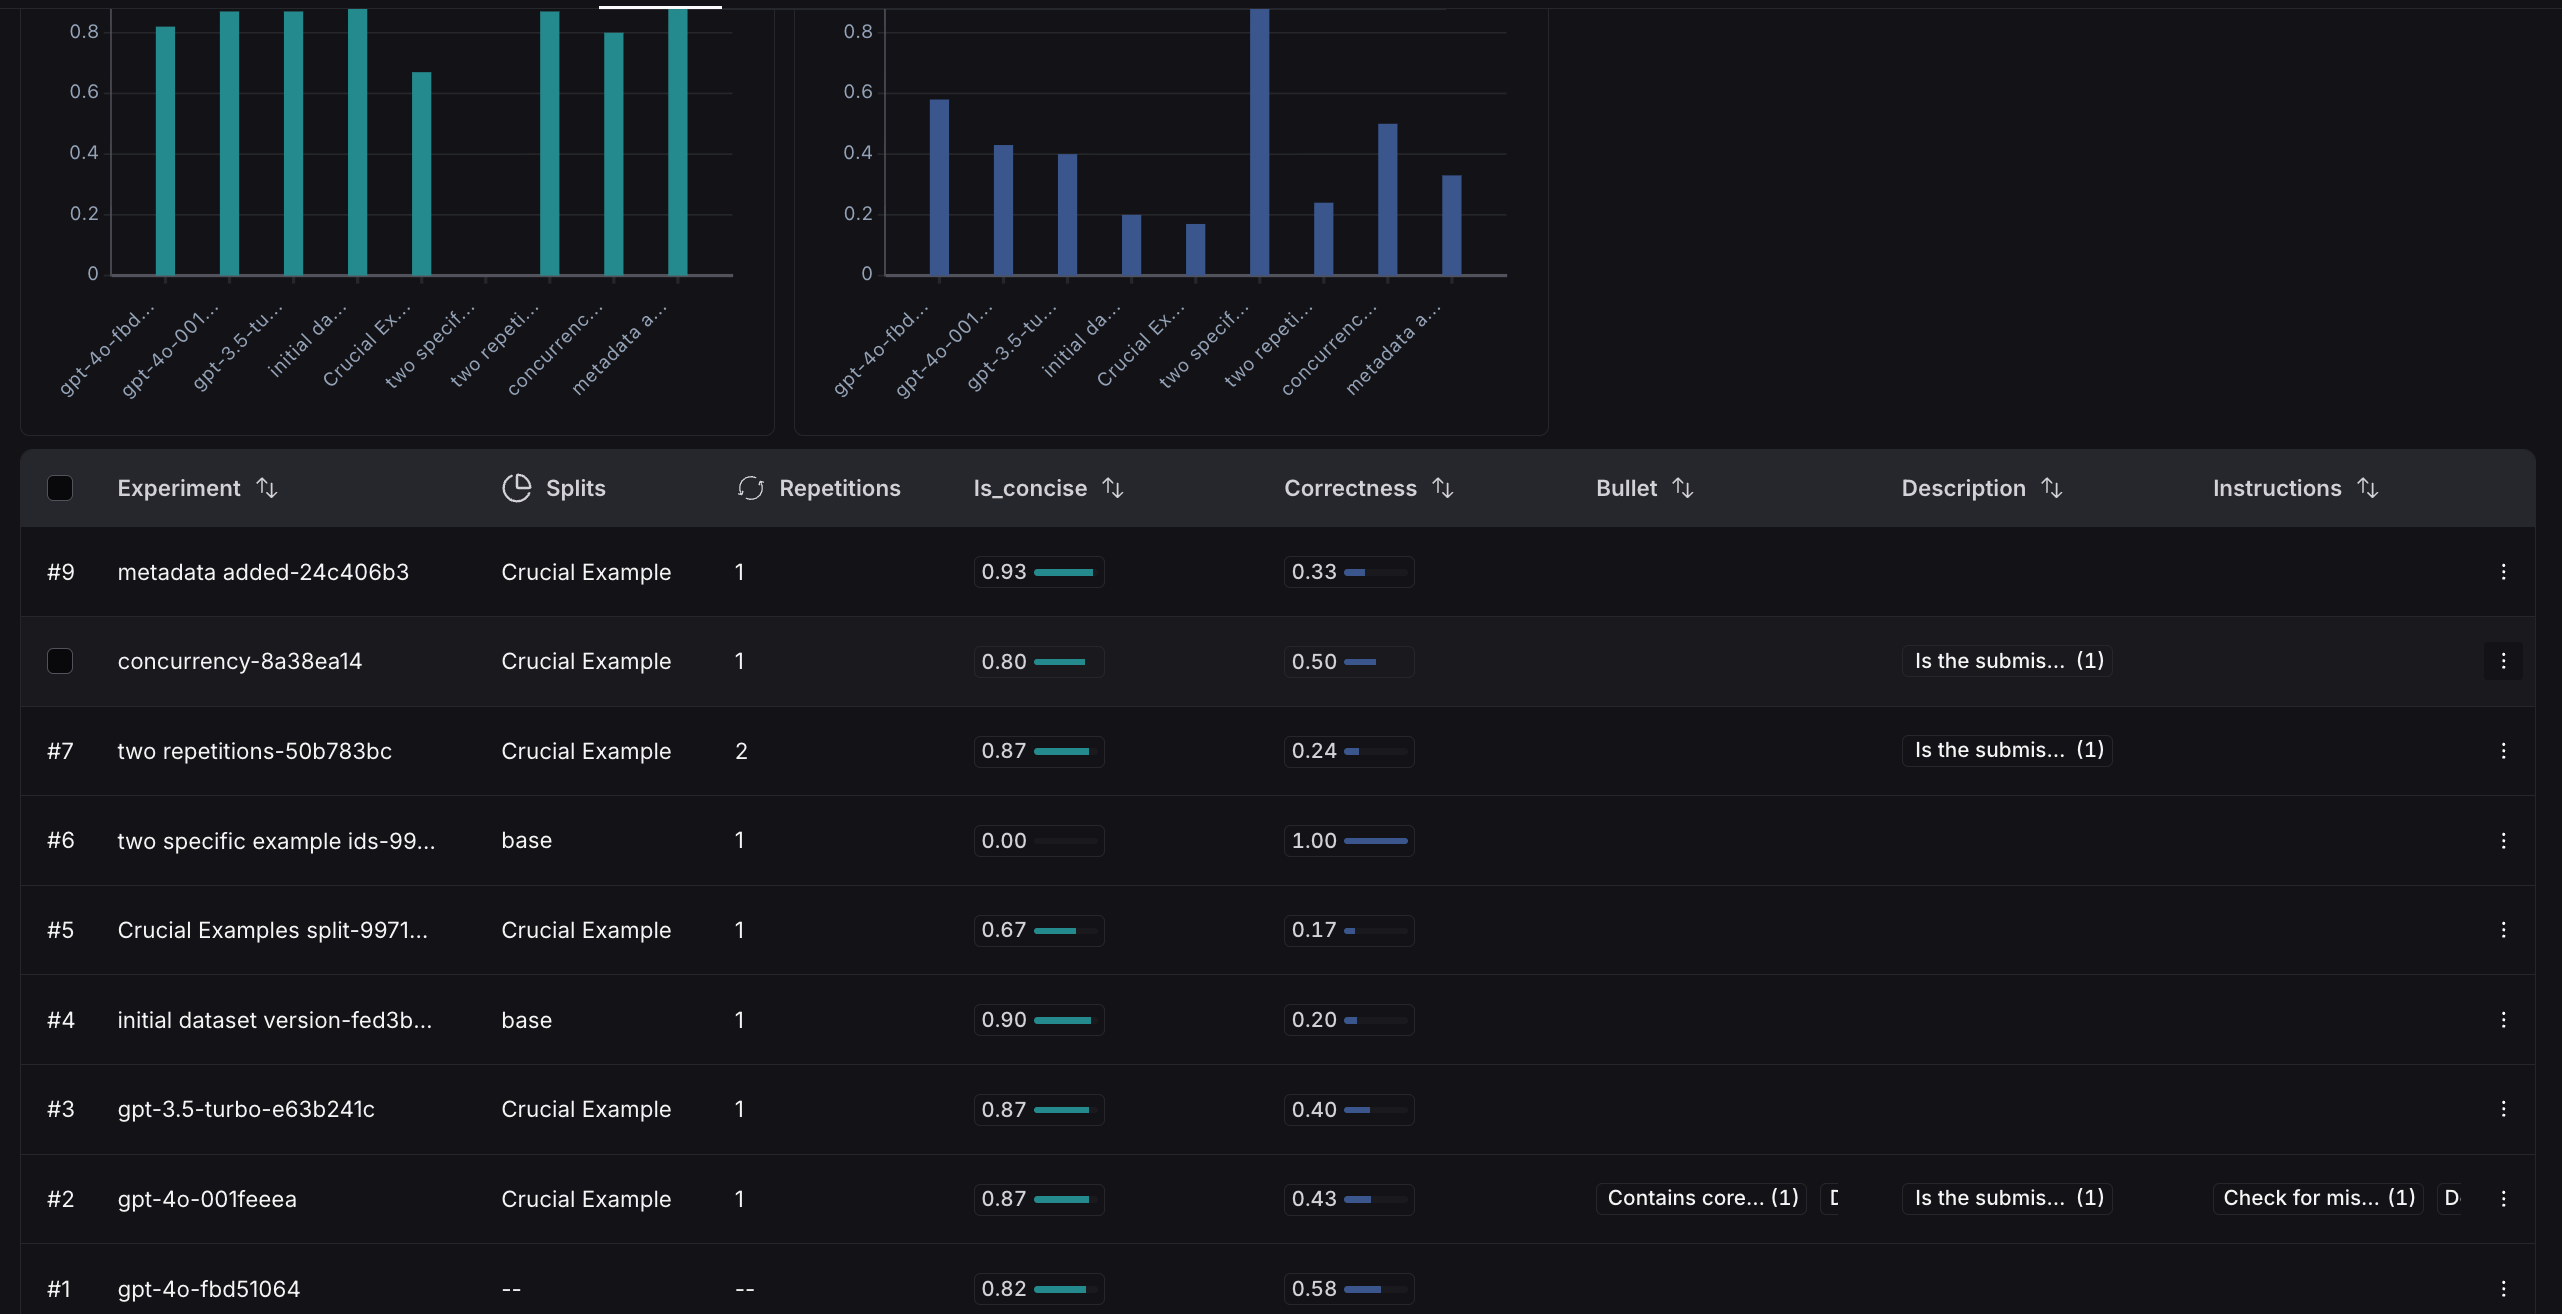